In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix

In [2]:
train_transform = [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
train_transform = transforms.Compose(train_transform)
num_workers = 0
batch_size = 40
train_data = datasets.MNIST(root='../data', train= True, download=False, transform=train_transform)
valid_data = datasets.MNIST(root='../data', train= True, download=False, transform=train_transform)
test_data = datasets.MNIST(root='../data', train= False, download=False, transform=train_transform)

C:\Users\prabh\anaconda3\envs\boston_house_prices_prediction\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
num_train = len(train_data)
data_idx = list(range(num_train))
split_idx = int(num_train * 0.05)
train_idx, valid_idx = data_idx[split_idx:], data_idx[:split_idx]

In [4]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size= batch_size,
                                           sampler = train_sampler,
                                           num_workers= num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size= batch_size,
                                           sampler = valid_sampler,
                                           num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size = batch_size, 
                                          num_workers = num_workers)

In [6]:
dataiter = iter(train_loader)
img, lbl = dataiter.next()
img.shape

torch.Size([40, 1, 28, 28])

In [7]:
# Declaring a neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = F.relu(self.fc1(x.view(batch_size,28*28)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
model = Net()
print(f'Total elements in the network : {sum([p.numel() for p in model.parameters()])}')

Total elements in the network : 407050


In [8]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

In [10]:
def validate_training():
    model.eval()
    valid_loss = 0.0    
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss / (len(valid_loader) * batch_size)
    print("Epoch {} : Validation loss : {:.6f}".format(epoch+1, valid_loss))
    return valid_loss

In [11]:
per_epoch_loss = []
validation_error = []
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    print("Epoch {} : Training loss : {:.6f}".format(epoch+1, train_loss))
    per_epoch_loss.append(train_loss)
    validation_error.append(validate_training())
    scheduler.step(train_loss)

Epoch 1 : Training loss : 1.312255
Epoch 1 : Validation loss : 0.757903
Epoch 2 : Training loss : 0.597169
Epoch 2 : Validation loss : 0.496480
Epoch 3 : Training loss : 0.456492
Epoch 3 : Validation loss : 0.412227
Epoch 4 : Training loss : 0.398572
Epoch 4 : Validation loss : 0.368589
Epoch 5 : Training loss : 0.363913
Epoch 5 : Validation loss : 0.340766
Epoch 6 : Training loss : 0.341017
Epoch 6 : Validation loss : 0.322278
Epoch 7 : Training loss : 0.322615
Epoch 7 : Validation loss : 0.305513
Epoch 8 : Training loss : 0.309741
Epoch 8 : Validation loss : 0.292895
Epoch 9 : Training loss : 0.297163
Epoch 9 : Validation loss : 0.282399
Epoch 10 : Training loss : 0.285316
Epoch 10 : Validation loss : 0.272657
Epoch 11 : Training loss : 0.276475
Epoch 11 : Validation loss : 0.264632
Epoch 12 : Training loss : 0.266746
Epoch 12 : Validation loss : 0.256669
Epoch 13 : Training loss : 0.260108
Epoch 13 : Validation loss : 0.249974
Epoch 14 : Training loss : 0.253367
Epoch 14 : Validatio

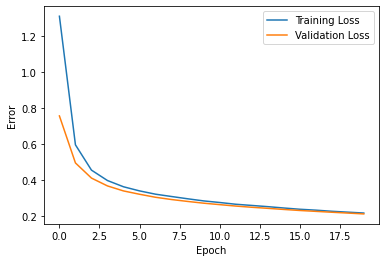

In [12]:
plt.plot(np.arange(20), per_epoch_loss, label='Training Loss')
plt.plot(np.arange(20), validation_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [12]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()*data.size(0)
    _, preds = torch.max(output, 1)
    correct = np.squeeze(preds.eq(target.data.view_as(preds)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print("Test loss : {:.6f}\n".format(test_loss))

Test loss : 0.211589



In [13]:
for i in range(10):
    print('Test accuracy of %5s : %2d%% (%2d / %2d )' % ( str(i), 100. * class_correct[i] / class_total[i], 
          np.sum(class_correct[i]), np.sum(class_total[i])))
print("Total accuracy : %2d%% (%2d / %2d)" % (100. *np.sum(class_correct) / np.sum(class_total) , 
                                              np.sum(class_correct), np.sum(class_total)))

Test accuracy of     0 : 98% (966 / 980 )
Test accuracy of     1 : 98% (1113 / 1135 )
Test accuracy of     2 : 92% (950 / 1032 )
Test accuracy of     3 : 94% (956 / 1010 )
Test accuracy of     4 : 95% (933 / 982 )
Test accuracy of     5 : 89% (800 / 892 )
Test accuracy of     6 : 95% (916 / 958 )
Test accuracy of     7 : 93% (957 / 1028 )
Test accuracy of     8 : 90% (884 / 974 )
Test accuracy of     9 : 92% (930 / 1009 )
Total accuracy : 94% (9405 / 10000)


In [14]:
dataiter = iter(test_loader)

<ipython-input-15-dc495100ef56>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])


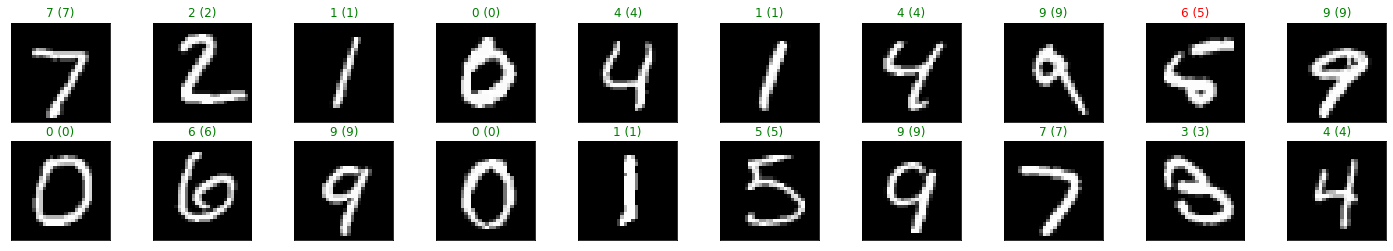

In [15]:
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), 
                 color= ("green" if preds[idx] == labels[idx] else "red"))

In [16]:
checkpoint = {"model" : model.state_dict(), 
               "optimizer" : optimizer.state_dict()}

In [17]:
def save_checkpoint(checkpoint, file_name = "checkpoint.pth.tar"):
    print("...saving checkpoint")
    torch.save(checkpoint, file_name)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("...loading checkpoint")
    model = model.load_state_dict(checkpoint['model'])
    optimizer = optimizer.load_state_dict(checkpoint['optimizer'])

In [18]:
save_checkpoint(checkpoint)

...saving checkpoint


In [19]:
import os
os.listdir()

['.ipynb_checkpoints', 'checkpoint.pth.tar', 'loadandsave.ipynb']

In [20]:
del checkpoint

In [21]:
model_loaded = Net()
optimizer_loaded = torch.optim.Adam(model_loaded.parameters())
checkpoints = torch.load('checkpoint.pth.tar')
load_checkpoint(checkpoints, model_loaded, optimizer_loaded)

...loading checkpoint


In [22]:
optimizer_loaded

Adam (
Parameter Group 0
    amsgrad: False
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [23]:
dataiter = iter(train_loader)

<ipython-input-24-9298d27f7002>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])


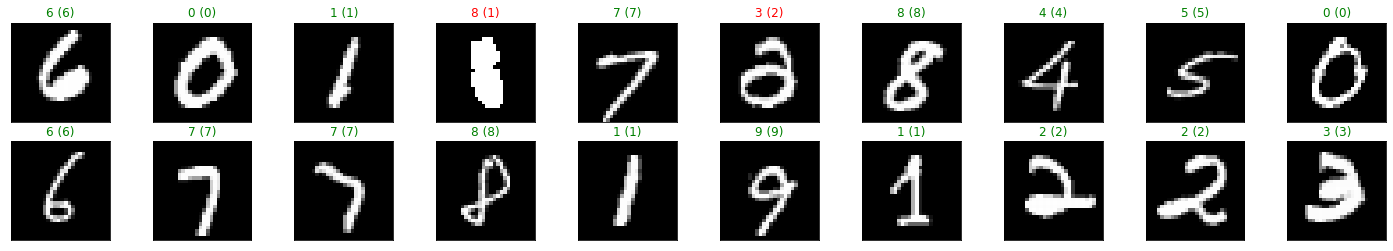

In [24]:
images, labels = dataiter.next()
output = model_loaded(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), 
                 color= ("green" if preds[idx] == labels[idx] else "red"))

### Pytorch tensor practice

In [27]:
a = torch.randn(1,2)
a

tensor([[ 1.3088, -0.2444]])

In [28]:
a.half()

tensor([[ 1.3086, -0.2444]], dtype=torch.float16)

In [29]:
a.long()

tensor([[1, 0]])

In [30]:
a.bool()

tensor([[True, True]])

In [31]:
torch.from_numpy(np.array([1,2,3,4,5]))

tensor([1, 2, 3, 4, 5], dtype=torch.int32)

In [37]:
torch.any(torch.zeros(2))

tensor(False)

In [44]:
b = torch.arange(9).view(3,3)
c = torch.arange(9).reshape(3,3)
b == c

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

In [52]:
c = c.t()

In [53]:
c.is_contiguous()

False

In [54]:
c.view(9)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [57]:
torch.contiguous_format

torch.contiguous_format

In [59]:
a = np.array([[1,2,3,4,5],[1,2,3,4,5]])

In [60]:
a.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [79]:
torch.arange(10).unsqueeze(0).unsqueeze(1).shape

torch.Size([1, 1, 10])

In [84]:
from torch.utils.tensorboard import SummaryWriter